<a href="https://colab.research.google.com/github/aleksl17/IKT440ptmc/blob/colab/Best_so_far.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached https://files.pythonhosted.org/packages/46/61/47d3235a4c13eec5a5f03594ddb268f4858734e02980afbcd806e6242fa5/pycuda-2020.1.tar.gz
     |████████████████████████████████| 71kB 4.0MB/s 
     |████████████████████████████████| 81kB 4.6MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621161 sha256=40f5f76e46a6b4d265f283b0c8216742ebc23ee64e478b4c3eba2e14c868ba4c
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=7177e19b71e5108e9b4bbdc55fbe637a2ed06a58b03989f34d0495d9b4fca764
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools
170500096/170498071 [==============================] - 3s 0us/step


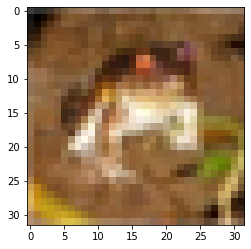

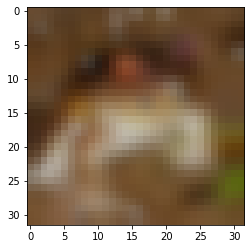

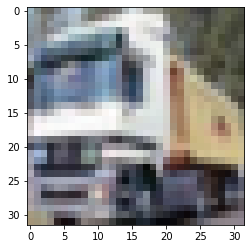

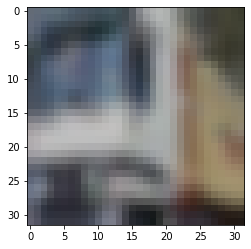


Accuracy over 50 epochs:

#1 Accuracy: 38.00%/39.04% Training: 460.83s Testing: 548.48s
#2 Accuracy: 41.98%/42.69% Training: 452.37s Testing: 554.05s
#3 Accuracy: 45.89%/46.43% Training: 455.24s Testing: 558.22s
#4 Accuracy: 48.24%/47.45% Training: 453.18s Testing: 552.17s
#5 Accuracy: 50.09%/48.73% Training: 449.24s Testing: 554.85s
#6 Accuracy: 51.98%/50.04% Training: 449.96s Testing: 546.98s
#7 Accuracy: 53.58%/51.02% Training: 448.67s Testing: 554.70s
#8 Accuracy: 55.29%/52.03% Training: 449.87s Testing: 538.75s
#9 Accuracy: 56.45%/52.75% Training: 446.23s Testing: 548.57s
#10 Accuracy: 57.56%/52.68% Training: 447.65s Testing: 546.90s
#11 Accuracy: 58.94%/53.61% Training: 447.74s Testing: 550.64s
#12 Accuracy: 60.21%/54.30% Training: 445.99s Testing: 542.77s
#13 Accuracy: 61.31%/54.91% Training: 444.72s Testing: 544.81s
#14 Accuracy: 62.81%/55.27% Training: 445.51s Testing: 538.48s
#15 Accuracy: 63.20%/55.29% Training: 442.80s Testing: 543.18s
#16 Accuracy: 64.61%/56.06% Training:

In [ ]:
!pip3 install pycuda
!pip3 install pyTsetlinMachineCUDA
!pip3 install opencv-python

from PyTsetlinMachineCUDA.tm import MultiClassConvolutionalTsetlinMachine2D
#import sys
#sys.path.append('../pyTsetlinMachine/')
#from tm import MultiClassConvolutionalTsetlinMachine2D
import numpy as np
from time import time
import copy
import matplotlib.pyplot as plt
import math
import imgaug


from keras.datasets import cifar10

import cv2

factor = 1
clauses = 8000*factor
T = 150*100*factor #threshold
s = 20.0 #learning sensitivity
patch = 6
img_size = 32

epochs = 50

labels = [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

tm = MultiClassConvolutionalTsetlinMachine2D(clauses, T, s, (patch, patch), number_of_state_bits=8, max_weight=255)
#tm = MultiClassConvolutionalTsetlinMachine2D(clauses, T, s, (patch, patch), weighted_clauses=True)

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

#do augmentation here
# Global Variables
augmentation_percentage = 30

# Import and manipulate dataset
a_p = math.floor((augmentation_percentage / 100) * len(X_train))
x_train_aug_before = copy.deepcopy(X_train[0:a_p])
x_train_aug_before = x_train_aug_before.astype("float32")

# Augmentation variables
seq = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(rotate=(-25, 25)),
    imgaug.augmenters.SaltAndPepper(p=(0, 0.1)),
    imgaug.augmenters.Crop(percent=(0, 0.25))
])

# Image augmentation
x_aug = seq.augment_images(x_train_aug_before)
y_aug = Y_train[0:a_p]

#do adaptive gaussian filtering here

def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

gaussian_images = []

for img in x_aug:
  new_img = cv2.filter2D(img, -1, gaussian_kernel(2,sigma=1))
  gaussian_images.append(new_img)

gaussian_images = np.array(gaussian_images)
gaussian_images = gaussian_images.astype(int)

plt.imshow(X_train[0])
plt.show()

plt.imshow(gaussian_images[0])
plt.show()

plt.imshow(X_train[1])
plt.show()

plt.imshow(gaussian_images[1])
plt.show()

#append augmented images to training data
X_train = np.concatenate((X_train, gaussian_images), axis=0)
Y_train = np.concatenate((Y_train, y_aug),axis=0)

#convert X to uint8
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)

#reshape dataset
Y_train=Y_train.reshape(Y_train.shape[0])
Y_test=Y_test.reshape(Y_test.shape[0])

#binarize
for i in range(X_train.shape[0]):
        for j in range(X_train.shape[3]):
                X_train[i,:,:,j] = cv2.adaptiveThreshold(X_train[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) #cv2.adaptiveThreshold(X_train[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 5)

for i in range(X_test.shape[0]):
        for j in range(X_test.shape[3]):
                X_test[i,:,:,j] = cv2.adaptiveThreshold(X_test[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)#cv2.adaptiveThreshold(X_test[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 5)


accuracy_history = []

print("\nAccuracy over %d epochs:\n" % epochs)
for i in range(epochs):
        start_training = time()
        tm.fit(X_train, Y_train, epochs=1, incremental=True)
        stop_training = time()

        start_testing = time()
        result_test = 100*(tm.predict(X_test) == Y_test).mean()
        accuracy_history.append(result_test)
        result_train= 100*(tm.predict(X_train) == Y_train).mean()
        stop_testing = time()

        print("#%d Accuracy: %.2f%%/%.2f%% Training: %.2fs Testing: %.2fs" % (i+1, result_train, result_test, stop_training-start_training, stop_testing-start_testing))


plt.plot(accuracy_history)
plt.show()

#testing

pred = tm.predict(X_test)

correct = 0
fail = 0
for i in range(len(X_test)):
  if pred[i] == Y_test[i]:
    correct += 1
  else:
    fail += 1

print("Testing Accuracy after "+ str(epochs) +" epochs:")
print(str(correct/(correct+fail)))

